In [1]:
%matplotlib inline

In [2]:
import os
import sys
import time

sys.path.append('/afs/crc.nd.edu/user/a/awoodard/releases/np-fit-production/CMSSW_7_4_7/python')
sys.path.append('/afs/crc.nd.edu/user/a/awoodard/.local/lib/python2.7/site-packages/')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

In [3]:
from NPFitProduction.NPFitProduction.cross_sections import parse_lhe_weights, CrossSectionScan

In [4]:
outdir = '/afs/crc.nd.edu/user/a/awoodard/www/.private/ttV/reweighting_v2'
lhe = '/afs/crc.nd.edu/user/a/awoodard/np-fit-production/test/reweight_v2/processtmp/Events/run_01/unweighted_events.lhe'
coefficients = ['cuB']

In [5]:
outdir = '/afs/crc.nd.edu/user/a/awoodard/www/.private/ttV/reweighting_v5'
lhe = '/afs/crc.nd.edu/user/a/awoodard/np-fit-production/test/reweight_v5/processtmp/Events/run_01/unweighted_events.lhe'
coefficients = ['cuW', 'cuB', 'cH', 'tc3G', 'c3G', 'cHu', 'c2G', 'cuG']

In [6]:
indices = dict((c, i) for i, c in enumerate(coefficients))

if not os.path.isdir(outdir):
    os.makedirs(outdir)

In [7]:
scan = CrossSectionScan('/hadoop/store/user/awoodard/ttV/cross_sections/25/merged/8d.npz')

`weights`: each row corresponds to an event, each column corresponds to a point

`points`: each row corresponds to a point, each column corresponds to a coefficient

In [8]:
points, weights = parse_lhe_weights(lhe, coefficients)

parsing /afs/crc.nd.edu/user/a/awoodard/np-fit-production/test/reweight_v5/processtmp/Events/run_01/unweighted_events.lhe
will process 277 points in 50000 events
completed 0 / 50000 events
completed 10000 / 50000 events
completed 20000 / 50000 events
completed 30000 / 50000 events
completed 40000 / 50000 events


In [32]:
start = time.time()
for event in range(len(weights)):
    constants, _, _, _ = np.linalg.lstsq(scan.model(points), weights[event])
print("fit {} points for {} events in {} seconds".format(len(points), len(weights), int(time.time() - start)))

fit 277 points for 50000 events in 137 seconds


In [31]:
test = [i for i in range(1, len(points)) if i % 20 == 0]
train = [i for i in range(1, len(points)) if i % 20 != 0]

errs = np.zeros((len(weights), len(points[test])))
fits = np.zeros((len(weights), len(points[test])))
start = time.time()
for event in range(len(weights)):
    constants, _, _, _ = np.linalg.lstsq(scan.model(points[train]), weights[event][train])
    fit = np.dot(scan.model(points[test]), constants)
    mg = weights[event][test]

    errs[event] = (mg - fit) / mg * 100
    fits[event] = fit

print('finished {} fits to {} points in {} seconds'.format(
    len(weights),
    len(points[train]),
    int(time.time() - start))
)

finished 50000 fits to 263 points in 150 seconds


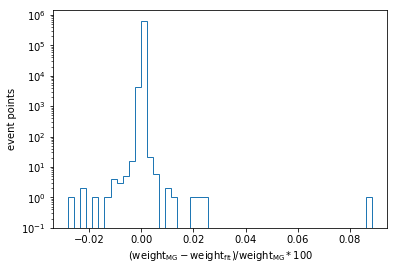

In [43]:
plt.hist(errs.ravel(), 50, histtype='step', log=True, fill=False)
plt.xlabel('$(\mathrm{weight}_{\mathrm{MG}} - \mathrm{weight}_{\mathrm{fit}}) / \mathrm{weight}_{\mathrm{MG}} * 100$')
plt.ylabel('event points')

plt.savefig(os.path.join(outdir, 'errs.pdf'), bbox_inches='tight')

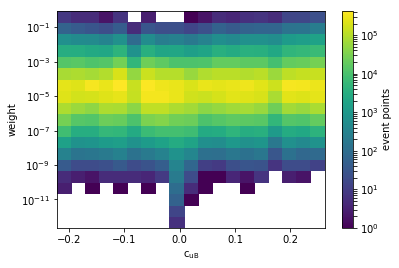

In [44]:
x = np.concatenate([points[:, indices['cuB']] for i in weights]).ravel()
y = weights.ravel()
bins = [
    np.linspace(x.min(), x.max(), 20),
    np.logspace(np.log10(y.min()), np.log10(y.max()), 20)
]

plt.yscale('log')
H, xedges, yedges = np.histogram2d(x, y, bins=bins)
plt.pcolormesh(xedges, yedges, H.T, norm=LogNorm())

plt.xlabel('$\mathrm{c}_\mathrm{uB}$')
plt.ylabel('weight')
plt.colorbar(label='event points')
plt.savefig(os.path.join(outdir, 'cuB_vs_weight.pdf'), bbox_inches='tight')

Above is the projection from the 8-dimensional space onto the cuB axis.

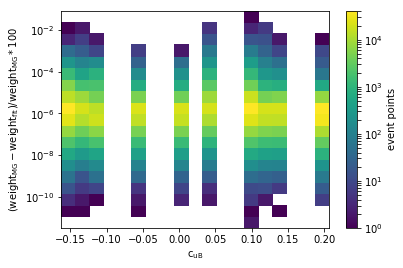

In [45]:
x = np.concatenate([points[test][:, indices['cuB']] for i in errs]).ravel()
y = np.abs(errs).ravel()

bins = [
    np.linspace(x.min(), x.max(), 20),
    np.logspace(np.log10(y.min()), np.log10(y.max()), 20)
]

plt.yscale('log')
H, xedges, yedges = np.histogram2d(x, y, bins=bins)
plt.pcolormesh(xedges, yedges, H.T, norm=LogNorm())
plt.xlabel('$\mathrm{c}_\mathrm{uB}$')
plt.ylabel('$(\mathrm{weight}_{\mathrm{MG}} - \mathrm{weight}_{\mathrm{fit}}) / \mathrm{weight}_{\mathrm{MG}} * 100$')
plt.colorbar(label='event points')
plt.savefig(os.path.join(outdir, 'cuB_vs_err.pdf'), bbox_inches='tight')

Note that the plot above only uses test points which were not included in the fit. The blank vertical bars correspond to the `train` points which were included in the fit.

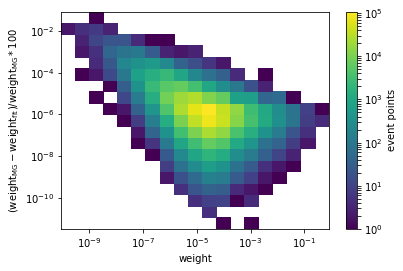

In [46]:
x = weights[:,test].ravel()
y = np.abs(errs.ravel())

bins = [
    np.logspace(np.log10(x.min()), np.log10(x.max()), 20),
    np.logspace(np.log10(y.min()), np.log10(y.max()), 20)
]

plt.xscale('log')
plt.yscale('log')
H, xedges, yedges = np.histogram2d(x, y, bins=bins)
plt.pcolormesh(xedges, yedges, H.T, norm=LogNorm())

plt.xlabel('weight')
plt.ylabel('$(\mathrm{weight}_{\mathrm{MG}} - \mathrm{weight}_{\mathrm{fit}}) / \mathrm{weight}_{\mathrm{MG}} * 100$')
plt.colorbar(label='event points')
plt.savefig(os.path.join(outdir, 'weight_vs_err.pdf'), bbox_inches='tight')

The only thing more confusing than a log log plot is a log log log plot.

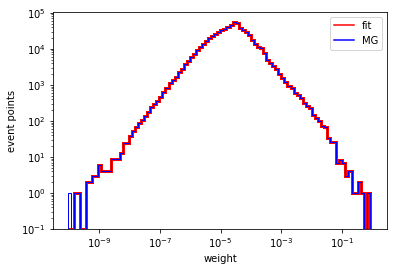

In [47]:
bins = np.logspace(np.log10(fits.min()), np.log10(fits.max()), 100)

plt.xscale('log')
plt.yscale('log')
plt.hist(fits.ravel(), bins=bins, histtype='step', fill=False, log=True, lw=3, color='red')
plt.hist(weights[:,test].ravel(), bins=bins, histtype='step', fill=False, log=True, color='blue')

fit_label, = plt.plot([0, 0], color='red')  # hack to show lines instead of boxes in the legend
mg_label, = plt.plot([0, 0], color='blue')

plt.xlabel('weight')
plt.ylabel('event points')
plt.legend([fit_label, mg_label], ['fit', 'MG'], loc='upper right')

plt.savefig(os.path.join(outdir, 'fit_and_mg.pdf'), bbox_inches='tight')


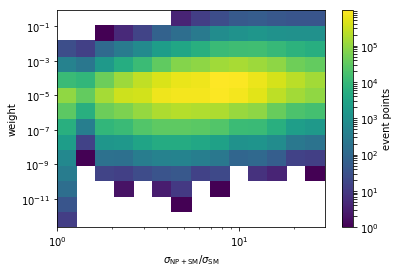

In [48]:
sm = sum(weights[:, 0])
scales = [sum(weights[:, i]) / sm for i in range(weights.shape[1])]

x = np.concatenate([scales for i in weights]).ravel()
y = weights.ravel()

bins = [
    np.logspace(np.log10(x.min()), np.log10(x.max()), 15),
    np.logspace(np.log10(y.min()), np.log10(y.max()), 15)
]

plt.xscale('log')
plt.yscale('log')
H, xedges, yedges = np.histogram2d(x, y, bins=bins)
plt.pcolormesh(xedges, yedges, H.T, norm=LogNorm())

plt.xlabel('$\sigma_\mathrm{NP+SM}/\sigma_\mathrm{SM}$')
plt.ylabel('weight')
plt.colorbar(label='event points')
plt.savefig(os.path.join(outdir, 'weight_vs_scale.pdf'), bbox_inches='tight')

In the above plot, all of the weights corresponding to each point are added to obtain the total cross section at that point. In the reweight card the first point is specified to be the SM point, so dividing the two gives you the scaling. This plot only means anything if the reweighting makes sense, which remains to be seen.

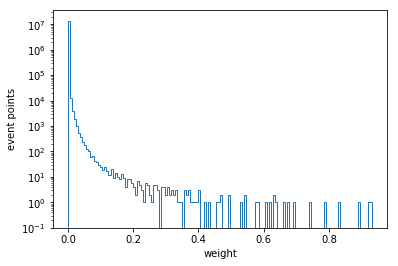

In [52]:
plt.hist(weights.ravel(), 150, histtype='step', log=True, fill=False)
plt.xlabel('weight')
plt.ylabel('event points')

plt.savefig(os.path.join(outdir, 'errs.pdf'), bbox_inches='tight')